In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import nlp

In [4]:
def show_history(h):
    epochs_trained= len(h.history['loss'])
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(range(0,epochs_trained),h.history.get('accuracy'),label='Training')
    plt.plot(range(0,epochs_trained),h.history.get('val_accuracy'),label='Validation')
    plt.ylim([0.,1.])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(0,epochs_trained),h.history.get('loss'),label='Training')
    plt.plot(range(0,epochs_trained),h.history.get('val_loss'),label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def show_confusion_matrix(y_true, y_pred,classes):
    from sklearn.metrics import confusion_matrix

    # Compute confusion matrix
    cm= confusion_matrix(y_true, y_pred,normalize='true')
    plt.figure(figsize=(8,8))
    sp=plt.subplot(1,1,1)
    cpx=sp.matshow(cm)
    plt.xticks(list(range(0,6)),labels=classes)
    plt.yticks(list(range(0,6)),labels=classes)
    plt.colorbar(cpx)
    plt.show()

In [5]:
#import dataset from hugginface using nlp library 
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [6]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [7]:
train = dataset['train']
test = dataset['test']
val=dataset['validation']

In [8]:
def get_data(dataset):
    tweet = []
    labels = []
    for i in range(len(dataset)):
        tweet.append(dataset[i]['text'])
        labels.append(dataset[i]['label'])
    return tweet,labels

In [9]:
tweet,labels=get_data(train) 

In [10]:
tweet[3],labels[3]

('i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'love')

In [11]:
#Tokenizer task where we convert the text into tokens or numbers
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000,oov_token='<UNK>') #make a tokenizer with 10000 most commonly used words and the unknown word
tokenizer.fit_on_texts(tweet)


In [12]:
tokenizer.texts_to_sequences([tweet[3]]) #convert the tweet into a list of tokens

[[2, 24, 165, 8, 665, 27, 6, 4158, 2, 59, 47, 9, 13, 22, 72, 30, 6, 3497]]

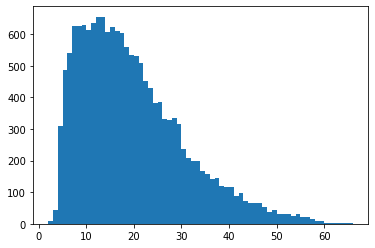

In [13]:
#Padding and truncating

lenghts = [len(t.split(' ')) for t in tweet]
plt.hist(lenghts,bins=len(set(lenghts)))
plt.show()


In [14]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences
def get_sequences(tokenizer,tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences (sequences,truncating='post',maxlen= maxlen,padding='post')
    return padded

In [15]:
padded_train_seq = get_sequences(tokenizer,tweet)
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

{'surprise', 'anger', 'fear', 'sadness', 'love', 'joy'}


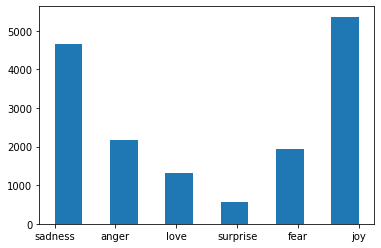

In [16]:
#preparing the labels
classes = set(labels)
print(classes)

plt.hist(labels,bins=11)
plt.show()

In [17]:
#dictionary to convert classes to their numeric values
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [18]:
class_to_index

{'surprise': 0, 'anger': 1, 'fear': 2, 'sadness': 3, 'love': 4, 'joy': 5}

In [19]:
index_to_class

{0: 'surprise', 1: 'anger', 2: 'fear', 3: 'sadness', 4: 'love', 5: 'joy'}

In [20]:
names_to_ids = lambda labels: np.array([class_to_index[l] for l in labels])

train_labels = names_to_ids(labels)
print(train_labels[0])

3


In [21]:
#creating the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [23]:
#training the model

val_tweets,val_labels = get_data(val)
val_seq = get_sequences(tokenizer,val_tweets)
val_labels = names_to_ids(val_labels)

val_tweets[1],val_labels[1]

('i feel like i am still looking at a blank canvas blank pieces of paper', 3)

In [24]:
h = model.fit(
    padded_train_seq,train_labels,
    validation_data=(val_seq,val_labels),
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2) #stop training if the validation accuracy does not improve after 2 epochs
    ]
)

Epoch 1/10
500/500 [==============================] - 16s 23ms/step - loss: 1.2405 - accuracy: 0.5227 - val_loss: 0.7568 - val_accuracy: 0.7255
Epoch 2/10
500/500 [==============================] - 10s 21ms/step - loss: 0.5078 - accuracy: 0.8239 - val_loss: 0.5328 - val_accuracy: 0.8115
Epoch 3/10
500/500 [==============================] - 11s 21ms/step - loss: 0.3050 - accuracy: 0.8960 - val_loss: 0.4783 - val_accuracy: 0.8360
Epoch 4/10
500/500 [==============================] - 12s 25ms/step - loss: 0.2292 - accuracy: 0.9237 - val_loss: 0.4593 - val_accuracy: 0.8495
Epoch 5/10
500/500 [==============================] - 12s 24ms/step - loss: 0.1799 - accuracy: 0.9413 - val_loss: 0.4304 - val_accuracy: 0.8615
Epoch 6/10
500/500 [==============================] - 12s 24ms/step - loss: 0.1364 - accuracy: 0.9564 - val_loss: 0.4281 - val_accuracy: 0.8750
Epoch 7/10
500/500 [==============================] - 12s 25ms/step - loss: 0.1126 - accuracy: 0.9622 - val_loss: 0.4201 - val_accuracy:

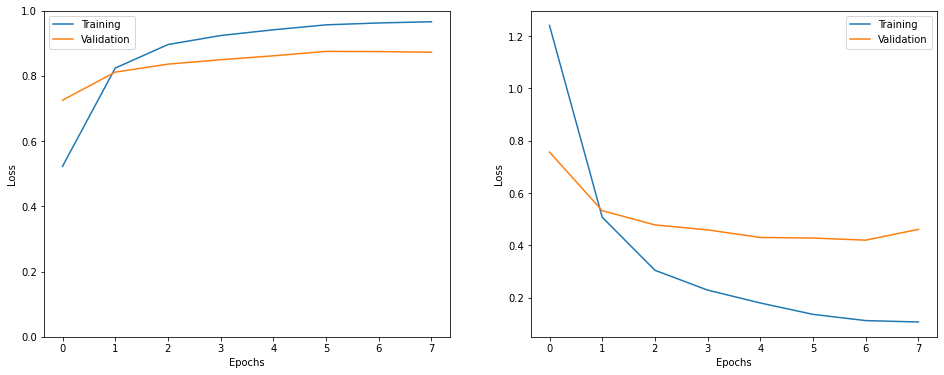

In [27]:
#validating the model

show_history(h)

In [28]:
test_tweets,test_labels = get_data(test)
test_seq = get_sequences(tokenizer,test_tweets)
test_labels = names_to_ids(test_labels)

_=model.evaluate(test_seq,test_labels)

63/63 [==============================] - 0s 6ms/step - loss: 0.4782 - accuracy: 0.8580


In [29]:
i = random.randint(0,len(test_labels) - 1)
print('Sentence: ',test_tweets[i])
print ('Emotion: ',index_to_class[test_labels[i]])

pred = model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class = index_to_class[np.argmax(pred).astype('uint8')]

print ('Predicted Emotion is: ',pred_class)

model.save('model.h5')

Sentence:  im feeling so damn gloomy too
Emotion:  sadness
Predicted Emotion is:  sadness
